## Problem 2. Nonnegative matrix factorization

__1.__ Download the the code below a dataset with photos and plot any of the samples.

In [9]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np

Shape of data = (400, 64, 64)


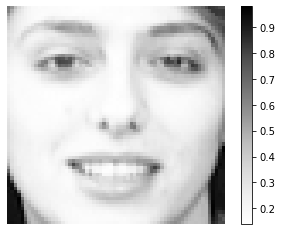

In [10]:
print("Shape of data = {}".format(data["images"].shape))
index = 75
#plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.imshow(1 - data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")


__2.__ One of the classical approach to image and in general signal processing is [nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)). 
Idea of the method is to solve the following optimization problem

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

where symbol $\geq$ denotes elementwise comparison. 
Also matrices $W$ and $H$ are lowrank, i.e. $W \in \mathbb{R}^{m \times k}$ and $H \in \mathbb{R}^{k \times n}$, where $k$ is a hyper-parameter that has to be tuned.
The larger $k$, the more accurate approximation, but more time is needed to solve the problem.
The matrix $X \in \mathbb{R}^{m \times n}$, where $m$ is a number of photos in our dataset, and $n$ is a umber of pixels in every picture, i.e. every row of the matrix $X$ is a vectorized image.

**Tasks**

1) (1 pts) is the above problem convex and why?

2) (1 pts) how can you interpret factors $W$ and $H$ and why its nonnegativity is important?

1. for convexity we need to check the second order derivative, if it is positive semi-definite or not:
$$
\frac{1}{2}  (X^2 - 2X^TWH +  (WH)^2)
$$
$$
\frac{d}{dH} = W^T(WH - X)
$$

$$
\frac{d}{dW} = (WH - X)H^T
$$

$$
H = \begin{bmatrix}
W^TW & 
    2WH - X\\
   2WH - X & 
   H^TH
\end{bmatrix}
$$

where, $(2WH - X)$ can be negative semi-definite, therefore, the problem is **not convex**

2. NMF aims at decomposing a given **nonnegative** data matrix X as $X ≈ WH$. Multiplication of nonnegative matrices W, H guarantees the nonnegativity of the matrix X and Nonnegativity of matrices can be advantageous from the point of view of interpretability. In image processing application $W$ matrix can be interpreted as the facial feature set of the data $X$, and $H$ matrix can be interpreted as the importance or weight of each facial feature.
W and H shall be component-wise nonnegative. If $W$ is nonnegative, the columns of $W$ can be interpreted as images (that is, vectors of pixel intensities) which we refer to as the basis images. As the weights in the linear combinations are nonnegative (H ≥ 0), these basis images can only be summed up to reconstruct each original image. 

### answer


__3.__ This problem can be approximately solved with CVXPy if the alternating optimization is used. The idea of this method is in even iterations solve the problem w.r.t $W$ while the matrix $H$ is fixed and in the odd iterations use optimal value of $W$ from the previous iteration as a fixed matrix and solve the problem w.r.t. $H$. And keep such alternating until convergence w.r.t. the changing the objective function.
Before run this method you need to initialize matrices $W$ and $H$ with some non-negative elements, probably random. The quality of the solution and running time of the method crucially depend on the initialization. So, you can test different approaches and report result of your investigation additionally.

**Tasks**

1) (2 pts) implement with CVXPy the alternating optimization method for this problem and solve it for some reasonable fixed $k$

2) (1 pts) plot the convergence line (objective function value vs. iteration idx) and confirm that the method converegs or the changing in objective function with iterating is very small

3) (1 pts) since the dimension of matrix $H$ is $k \times n$, then every row of $H$ can be transformed to photo in the inverse manner like they were collected in rows of matrix $X$. Plot 10-50 pictures extracted from rows of matrix $H$. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use ```plt.colorbar()``` and colour scheme ```plt.cm.Greys``` for more constrast displaying the pixels

4) (1 pts) Plot matrix $W$ with functions ```plt.imshow``` or ```plt.spy``` from the ```matplotlib``` library. How much sparse is it?

In [11]:
# Ensure repeatably random problem data.
np.random.seed(20)

# Initialize W and H matrices randomly.
m = 50
k = 30 # every row of  H can be transformed to photo in the inverse manner
n = 4096
W = np.random.rand(m, k)
H = np.random.rand(k, n)

In [12]:
# data in rows (m) of X 
X = data.data[:m,] 

# Perform alternating minimization.
MAX_ITERS = 8
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # in the odd iterations use optimal value of  W 
    # from the previous iteration as a fixed matrix and solve the problem w.r.t.  𝐻
    if iter_num % 2 == 1:
        H = cvx.Variable(shape=(k, n))
        constraint = [H >= 0]
    # in even iterations solve the problem w.r.t  𝑊, while the matrix  𝐻
    else:
        W = cvx.Variable(shape=(m, k))
        constraint = [W >= 0]

  # Solve the problem.
    obj = cvx.Minimize(0.5 * cvx.norm(X - W * H, 'fro'))
    prob = cvx.Problem(obj, constraint)
    # prob = cvx.Problem(obj)
    prob.solve(verbose=True, solver=cvx.SCS, max_iters=10000)

    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")

    print('Iteration {}, residual squared norm {}'.format(iter_num, prob.value))
    residual[iter_num-1] = prob.value

    if iter_num % 2 == 1:
        H = H.value
    else:
        W = W.value

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 22 02:33:41 AM: Your problem has 122880 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 22 02:33:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 02:33:41 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 02:33:41 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 22 02:33:41 AM: Compiling problem (target solver=SCS).
(CVXPY) Jan 22 02:33:41 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

(CVXPY) Jan 22 02:36:37 AM: Optimal value: 1.360e+01
(CVXPY) Jan 22 02:36:37 AM: Compilation took 1.222e+02 seconds
(CVXPY) Jan 22 02:36:37 AM: Solver (including time spent in interface) took 3.988e+01 seconds
Iteration 2, residual squared norm 13.601835068034296
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 22 02:36:37 AM: Your problem has 122880 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 22 02:36:37 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 02:36:37 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 02:36:37 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation           

(CVXPY) Jan 22 02:39:25 AM: Optimal value: 1.002e+01
(CVXPY) Jan 22 02:39:25 AM: Compilation took 1.152e+02 seconds
(CVXPY) Jan 22 02:39:25 AM: Solver (including time spent in interface) took 3.378e+01 seconds
Iteration 4, residual squared norm 10.01937821860504
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 22 02:39:25 AM: Your problem has 122880 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 22 02:39:25 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 02:39:25 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 02:39:25 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation            

  1800| 3.81e-03  3.54e-04  1.49e-05  9.21e+00  9.21e+00  1.39e-16  8.79e+01 
  1820| 8.92e-05  9.06e-06  3.27e-08  9.21e+00  9.21e+00  7.43e-16  8.88e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.88e+01s
	Lin-sys: nnz in L factor: 6396803, avg solve time: 2.60e-02s
	Cones: avg projection time: 4.71e-04s
	Acceleration: avg step time: 1.48e-02s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3145e-13, dist(y, K*) = 2.8311e-15, s'y/|s||y| = -1.4409e-14
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 8.9177e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.0561e-06
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.2694e-08
----------------------------------------------------------------------------
c'x = 9.2085, -b'y = 9.2085
-------------------------------------------------------------------------------
                                    Summary                     

   200| 4.40e-03  1.89e-04  3.41e-05  8.77e+00  8.77e+00  2.14e-16  9.52e+00 
   300| 2.90e-04  2.13e-05  6.11e-06  8.77e+00  8.77e+00  6.78e-16  1.43e+01 
   400| 1.50e-01  9.93e-03  1.74e-04  8.77e+00  8.77e+00  3.91e-17  1.85e+01 
   500| 7.72e-03  5.38e-04  1.05e-05  8.77e+00  8.77e+00  4.52e-16  2.27e+01 
   600| 1.26e-02  7.47e-04  3.32e-05  8.77e+00  8.77e+00  5.51e-16  2.68e+01 
   700| 5.33e-03  4.48e-04  6.30e-05  8.77e+00  8.77e+00  1.05e-16  3.09e+01 
   800| 6.29e-03  4.91e-04  1.81e-06  8.77e+00  8.77e+00  1.00e-16  3.51e+01 
   900| 4.00e-04  2.72e-05  3.82e-05  8.77e+00  8.77e+00  3.43e-16  3.92e+01 
  1000| 1.29e-01  8.31e-03  2.29e-04  8.76e+00  8.76e+00  4.89e-17  4.34e+01 
  1100| 1.05e+00  6.63e-02  3.88e-04  8.77e+00  8.76e+00  1.38e-16  4.75e+01 
  1200| 3.59e-02  2.88e-03  8.42e-05  8.77e+00  8.77e+00  2.73e-16  5.21e+01 
  1300| 5.31e-02  4.72e-03  2.64e-05  8.77e+00  8.77e+00  1.81e-17  5.69e+01 
  1400| 1.46e-04  1.28e-05  3.54e-06  8.77e+00  8.77e+00  2.40e-

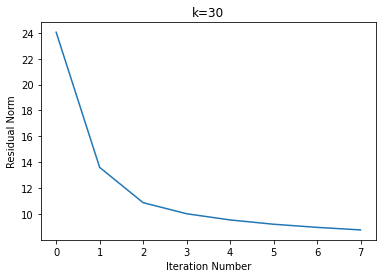

Residual after 8 iterations: 8.769572536232957


In [13]:
# Create the plot.
plt.plot(residual)
plt.xlabel('Iteration Number')
plt.ylabel('Residual Norm')
plt.title(f"k={k}")
plt.show()

print('Residual after {} iterations: {}'.format(iter_num, prob.value))

3) (1 pts) since the dimension of matrix $H$ is $k \times n$, then every row of $H$ can be transformed to photo in the inverse manner like they were collected in rows of matrix $X$. Plot 10-50 pictures extracted from rows of matrix $H$. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use ```plt.colorbar()``` and colour scheme ```plt.cm.Greys``` for more constrast displaying the pixels

In [14]:
m, w, h = data["images"].shape

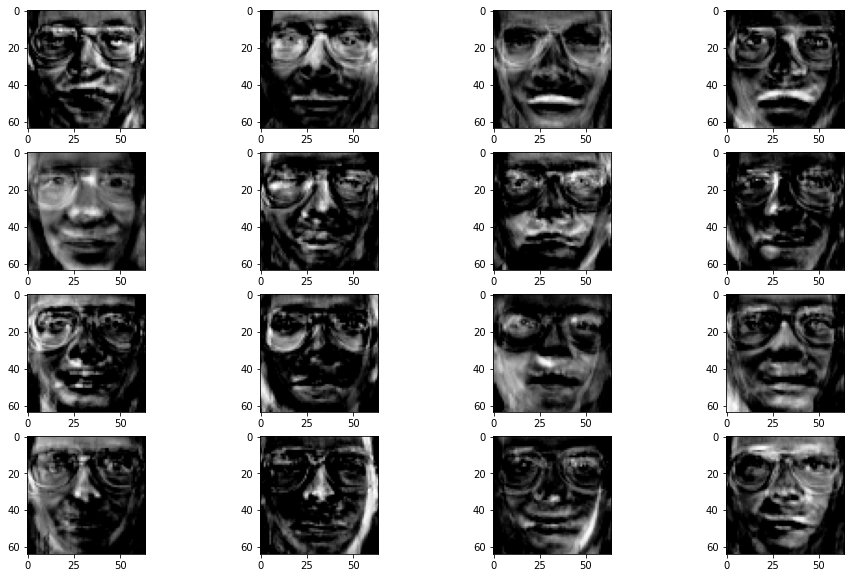

In [15]:
fig = plt.figure(figsize=(16,10))
columns = 4
rows = 4
for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(np.array(1-H[i - 1,:]).reshape(w, h), cmap=plt.cm.Greys)

plt.show()

The reason why NMF has become so popular is because of its ability to automatically extract sparse and easily interpretable factors. The columns of H indicate which feature is present in which image, we have only 8 iterations and k=30, which lead to the residual = 8.8, nevertheless we can distinguish those features such as eyes, noses, mustaches, and lips.

4) (1 pts) Plot matrix $W$ with functions ```plt.imshow``` or ```plt.spy``` from the ```matplotlib``` library. How much sparse is it?

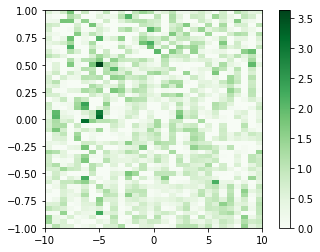

In [18]:
plt.imshow(W, cmap='Greens', extent=[-10,10,-1,1], aspect=10)
plt.colorbar()

we can see that, NMF reduces the features, therefore the W matrix is sparse

How much sparse is it?

In [19]:
w = W.ravel()
for i in range(len(w)):
    w[i] = w[i]/max(w)
    if w[i] < 0.15:
        w[i] = 0
(len(w) - np.count_nonzero(w))/len(w)

0.486

if we consider as sparse the values < 0.15, where max value after normalaizing is equal to 1, then the 48% of values are less than 0.15